## List 2

In [373]:
import numpy as np
import polars as pl

In the following tasks use the matrix multiplication form of Ordinary Least Squares (OLS) to fit a linear model to the data.

First, load the US consumption expenditure data from the file `consumption.csv`

In [374]:
df = pl.read_csv('data/consumption.csv', separator='\t', has_header=True)
df

Quarter,Consumption,Income,Production,Savings,Unemployment
f64,f64,f64,f64,f64,f64
1970.0,0.618566,1.044801,-2.452486,5.299014,0.9
1970.25,0.451984,1.225647,-0.551459,7.789894,0.5
1970.5,0.872872,1.585154,-0.358652,7.403984,0.5
1970.75,-0.271848,-0.239545,-2.185691,1.169898,0.7
1971.0,1.901345,1.975925,1.909764,3.535667,-0.1
…,…,…,…,…,…
2018.25,0.983112,0.661825,1.117424,-2.723974,0.0
2018.5,0.853181,0.806271,1.256722,-0.085686,-0.3
2018.75,0.356512,0.695142,0.948148,5.031337,0.2


## Task 1
Fit the following regression model:

$$ \hat{y}_t = \beta_0 + \beta_1 x_{1,t} + \beta_2 x_{2,t}, $$

where $y$ is the **Consumption**, $x_1$ is the **Income** and $x_2$ is the **Production** variable.

In [375]:
def OLS(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

In [376]:
X = df.select(pl.col("Income"), pl.col("Production")).to_numpy()
X = np.column_stack((np.ones(len(X)), X)) # add column of ones to fit the intercept
y = df.select(pl.col("Consumption")).to_numpy()

beta = OLS(X, y)
print(beta)

[[0.51067899]
 [0.18428111]
 [0.19250382]]


## Task 2

From all available explanatory variables select the optimal regression model structure with the cross validation framework (leave-one-out cross validation).

In [377]:
def leave_one_out(X, y):
    n = X.shape[0]
    sse = 0.0 # sum of squared errors
    for i in range(n):
        
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i, axis=0)

        beta = OLS(X_train, y_train)
        
        X_test = X[i, :]
        prediction = X_test @ beta

        sse += (y[i] - prediction).item() ** 2

    return sse / n

In [378]:
import itertools

In [379]:
target = 'Consumption'
regressors = df.columns
regressors.remove(target)
print(regressors)

['Quarter', 'Income', 'Production', 'Savings', 'Unemployment']


In [380]:
mse = dict()
y = df.select(pl.col(target)).to_numpy()
counter = 0
for r in range(1, len(regressors) + 1):
    for regressor_subset in itertools.combinations(regressors, r):
        X = df.select(pl.col(regressor_subset)).to_numpy()
        X = np.column_stack((np.ones(len(X)), X))
        mse[counter] = (
            list(regressor_subset), 
            leave_one_out(X, y)
        )
        counter += 1
#
# sort the dictionary by the second element of the tuple stored in the values
sorted(mse.items(), key = lambda item: item[1][1])

[(27, (['Quarter', 'Income', 'Savings', 'Unemployment'], 0.10127551446945618)),
 (30,
  (['Quarter', 'Income', 'Production', 'Savings', 'Unemployment'],
   0.10194997388252386)),
 (29,
  (['Income', 'Production', 'Savings', 'Unemployment'], 0.10389717717861517)),
 (23, (['Income', 'Savings', 'Unemployment'], 0.10421855311779221)),
 (25, (['Quarter', 'Income', 'Production', 'Savings'], 0.10473467525066035)),
 (21, (['Income', 'Production', 'Savings'], 0.10496368365747437)),
 (16, (['Quarter', 'Income', 'Savings'], 0.11415995882515444)),
 (10, (['Income', 'Savings'], 0.11443969176896497)),
 (26,
  (['Quarter', 'Income', 'Production', 'Unemployment'], 0.2636896162266049)),
 (17, (['Quarter', 'Income', 'Unemployment'], 0.2644193328601789)),
 (28,
  (['Quarter', 'Production', 'Savings', 'Unemployment'], 0.2697336871906734)),
 (22, (['Income', 'Production', 'Unemployment'], 0.2706642802968705)),
 (20, (['Quarter', 'Savings', 'Unemployment'], 0.27442663912848236)),
 (11, (['Income', 'Unemploy

For the remaining tasks we will use the GEFCOM dataset. First, load it from the `gefcom.txt` file:

In [381]:
df = pl.read_csv("data/gefcom.txt", separator='\t', has_header=True)
df

Date,Hour,Price,SystemLoad,Load,Weekday,
f64,f64,f64,f64,f64,f64,str
2.0110101e7,0.0,43.17,15187.0,5091.0,6.0,null
2.0110101e7,1.0,36.24,14464.0,4918.0,6.0,null
2.0110101e7,2.0,34.64,13940.0,4763.0,6.0,null
2.0110101e7,3.0,33.76,13609.0,4660.0,6.0,null
2.0110101e7,4.0,33.08,13391.0,4599.0,6.0,null
…,…,…,…,…,…,…
2.0131217e7,19.0,113.92,23091.0,7167.0,2.0,null
2.0131217e7,20.0,107.26,22504.0,6958.0,2.0,null
2.0131217e7,21.0,89.02,21538.0,6707.0,2.0,null


In [382]:
# cast hour and weekday into integers and drop the last column that has empty name ("")
df = df.with_columns(
    pl.col("Hour").cast(pl.UInt8),
    pl.col("Weekday").cast(pl.UInt8),
).drop(pl.col(""))
df

Date,Hour,Price,SystemLoad,Load,Weekday
f64,u8,f64,f64,f64,u8
2.0110101e7,0,43.17,15187.0,5091.0,6
2.0110101e7,1,36.24,14464.0,4918.0,6
2.0110101e7,2,34.64,13940.0,4763.0,6
2.0110101e7,3,33.76,13609.0,4660.0,6
2.0110101e7,4,33.08,13391.0,4599.0,6
…,…,…,…,…,…
2.0131217e7,19,113.92,23091.0,7167.0,2
2.0131217e7,20,107.26,22504.0,6958.0,2
2.0131217e7,21,89.02,21538.0,6707.0,2


## Task 3
Using the first 365 days, for each hour fit the following regression model:
    $$ \hat{P}_{d,h} = \beta_0 + \beta_1 P_{d-1,h} + \beta_2 P_{d-7,h}, $$
where $P_{d,h}$ is the electricity price for day $d$ and hour $h$. Plot the values of $\hat{\beta_1}$ and $\hat{\beta_2}$ for each hour.

In [383]:
betas = np.full((3, 24), np.nan)

for h in range(0, 24):
    # filter by hour and take the first 365 days
    df_hour = df.filter(pl.col("Hour")==h).slice(0, 365)
    
    # add lags and drop nulls
    df_hour = df_hour.with_columns(
        pl.col("Price").shift(1).alias("PriceLag1"),
        pl.col("Price").shift(7).alias("PriceLag7")
    ).drop_nulls()
    P = df_hour.select(pl.col("Price")).to_numpy()
    X = df_hour.select(pl.col(["PriceLag1", "PriceLag7"])).to_numpy()
    X = np.column_stack((np.ones(len(X)), X))
    betas[:, h] = OLS(X, P).ravel() # apply ravel() to turn an array of size (3, 1) to an array of size (3, )

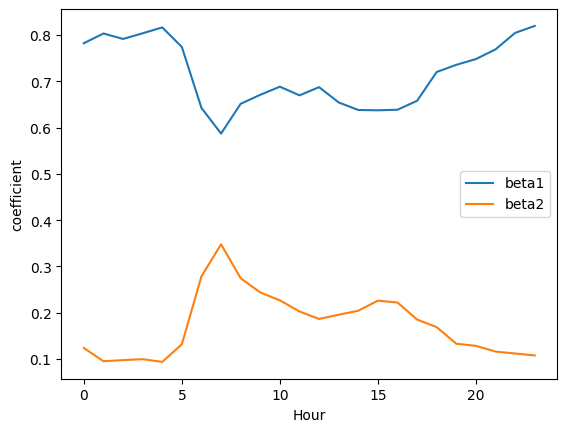

In [384]:
import matplotlib.pyplot as plt

plt.plot(range(0, 24), betas[1, :], label="beta1")
plt.plot(range(0, 24), betas[2, :], label="beta2")
plt.ylabel("coefficient")
plt.xlabel("Hour")
plt.legend()

## Task 4
Using the first 365 days, for each hour fit the following regression model:
    $$ \hat{P}_{d,h} = \beta_0 + \beta_1 P_{d-1,h} + \beta_2 P_{d-2,h} + \beta_3 P_{d-7,h} + \beta_4 L_{d,h} + \sum_{i=1}^{6} \beta_{i+4} D_{d, i} $$ 
where $D_{d,i}$ is the dummy variable for day $d$ representing $i$-th day of the week. Using the estimated parameters produce price forecasts for days 366-1082.

In [385]:
# create dummies from the Weekday column
df = df.to_dummies("Weekday") 
df

Date,Hour,Price,SystemLoad,Load,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7
f64,u8,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8
2.0110101e7,0,43.17,15187.0,5091.0,0,0,0,0,0,1,0
2.0110101e7,1,36.24,14464.0,4918.0,0,0,0,0,0,1,0
2.0110101e7,2,34.64,13940.0,4763.0,0,0,0,0,0,1,0
2.0110101e7,3,33.76,13609.0,4660.0,0,0,0,0,0,1,0
2.0110101e7,4,33.08,13391.0,4599.0,0,0,0,0,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…
2.0131217e7,19,113.92,23091.0,7167.0,0,1,0,0,0,0,0
2.0131217e7,20,107.26,22504.0,6958.0,0,1,0,0,0,0,0
2.0131217e7,21,89.02,21538.0,6707.0,0,1,0,0,0,0,0


In [386]:
# add lagged variables - notice that this approach is different from Task 3 but also viable 
df = df.with_columns(
    pl.col("Price").shift(24).alias("PriceLag1"),
    pl.col("Price").shift(48).alias("PriceLag2"),
    pl.col("Price").shift(168).alias("PriceLag7")
)
df

Date,Hour,Price,SystemLoad,Load,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7,PriceLag1,PriceLag2,PriceLag7
f64,u8,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,f64,f64,f64
2.0110101e7,0,43.17,15187.0,5091.0,0,0,0,0,0,1,0,null,null,null
2.0110101e7,1,36.24,14464.0,4918.0,0,0,0,0,0,1,0,null,null,null
2.0110101e7,2,34.64,13940.0,4763.0,0,0,0,0,0,1,0,null,null,null
2.0110101e7,3,33.76,13609.0,4660.0,0,0,0,0,0,1,0,null,null,null
2.0110101e7,4,33.08,13391.0,4599.0,0,0,0,0,0,1,0,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2.0131217e7,19,113.92,23091.0,7167.0,0,1,0,0,0,0,0,138.15,98.03,63.34
2.0131217e7,20,107.26,22504.0,6958.0,0,1,0,0,0,0,0,135.53,90.93,57.0
2.0131217e7,21,89.02,21538.0,6707.0,0,1,0,0,0,0,0,110.64,85.37,53.52


In [387]:
betas = np.full((11, 24), np.nan)

for h in range(0, 24):
    # filter by hour, take the first 365 days and drop nulls
    df_hour = df.filter(pl.col("Hour")==h).slice(0, 365).drop_nulls()

    P = df_hour.select(pl.col("Price")).to_numpy()
    X = df_hour.select(pl.col(
        ["PriceLag1", "PriceLag2", "PriceLag7", "SystemLoad", 
         "Weekday_1", "Weekday_2", "Weekday_3", "Weekday_4", "Weekday_5", "Weekday_6"]
         )).to_numpy()

    X = np.column_stack((np.ones(len(X)), X))
    betas[:, h] = OLS(X, P).ravel() # apply ravel() to turn an array of size (11, 1) to an array of size (11, )


We estimated all the coefficients for our linear regression models, now we can generate forecasts starting from the 366-th day

In [388]:
first_day = 365 # index 365 is the 366-th day since we index from 0
test_window = len(df)//24 - first_day
forecasts = np.full((test_window, 24), np.nan)

for h in range(0, 24):
    
    df_hour = df.filter(pl.col("Hour")==h).slice(first_day)

    P = df_hour.select(pl.col("Price")).to_numpy()
    X = df_hour.select(pl.col(
        ["PriceLag1", "PriceLag2", "PriceLag7", "SystemLoad", 
         "Weekday_1", "Weekday_2", "Weekday_3", "Weekday_4", "Weekday_5", "Weekday_6"]
         )).to_numpy()
    X = np.column_stack((np.ones(len(X)), X))

    forecasts[:, h] = X @ betas[:, h].T

forecasts

array([[32.13393574, 29.73568552, 27.03982893, ..., 41.16182116,
        35.00293687, 32.05091797],
       [29.87217141, 28.99700496, 26.63721686, ..., 55.09506668,
        34.0529848 , 33.23333009],
       [33.68869897, 29.98828978, 28.29436341, ..., 53.63768816,
        45.51752712, 36.75534982],
       ...,
       [59.85226538, 52.01039185, 60.89472974, ..., 81.68302393,
        64.81898677, 85.92797207],
       [61.76693581, 59.86184457, 50.37519641, ..., 76.5998423 ,
        64.92541755, 60.36491082],
       [61.14415792, 51.96811266, 63.62679455, ..., 97.43000092,
        79.8815552 , 79.05465732]], shape=(717, 24))

In the end, create a polars dataframe that only contains testing data

In [389]:
df = df.slice(first_day*24)
df = df.with_columns(Forecasts = pl.Series(forecasts.flatten()))  
# note that flatten() by default applies the row-major order, you can read more details at https://numpy.org/doc/2.3/reference/generated/numpy.ndarray.flatten.html
# our forecasts are in the (days, hours) shape, so we want the row-major order
# if we stored our forecasts in the (hours, day) shape, then we would have to call `flatten(order='F')` to apply the column-major order
df.select(pl.col("Date", "Hour", "Price", "Forecasts"))

Date,Hour,Price,Forecasts
f64,u8,f64,f64
2.0120101e7,0,31.68,32.133936
2.0120101e7,1,29.88,29.735686
2.0120101e7,2,27.01,27.039829
2.0120101e7,3,26.06,26.687851
2.0120101e7,4,25.64,26.302728
…,…,…,…
2.0131217e7,19,113.92,120.377773
2.0131217e7,20,107.26,118.955172
2.0131217e7,21,89.02,97.430001


Finally, let us calculate MAE and MSE of the Forecasts

In [390]:
df.select(
    np.abs(pl.col("Price")-pl.col("Forecasts")).mean().alias("MAE"),
    np.square(pl.col("Price")-pl.col("Forecasts")).mean().alias("MSE")
)

MAE,MSE
f64,f64
7.074842,170.208335
